# Investigation of Accessible UA to a Mini-Split Indoor Unit

Look at known, funcational single-point heating systems and the UA associated with the space they are heating.

In [1]:
import io
import urllib
import functools
import pandas as pd
import requests
# import matplotlib pyplot commands
from matplotlib.pyplot import *
from IPython.display import Image, Markdown
 
# Show Plots in the Notebook
%matplotlib inline
 
# 'style' the plot like fivethirtyeight.com website
style.use('bmh')

In [2]:
rcParams['figure.figsize']= (10, 8)   # set Chart Size
rcParams['font.size'] = 14            # set Font size in Chart

### Utility Functions

In [6]:
# Function to retrieve Alaska Energy Data, particularly TMY3

# The base URL to the site where the remote files are located
base_url = 'http://ak-energy-data.analysisnorth.com/'

# They also can be pulled from the GitHub repo using the rawgit.com service.
# The advantage is that you point to a particular commit, so the files and their
# structure will never change.
#base_url = 'https://cdn.rawgit.com/alanmitchell/ak-energy-admin/75db23ba/data/'

@functools.lru_cache(maxsize=None)   # cache results
def get_df(file_path):
    """Returns a Pandas DataFrame that is found at the 'file_path'
    below the Base URL for accessing data.  The 'file_path' should end
    with '.pkl' and points to a pickled, compressed (bz2), Pandas DataFrame.
    """
    b = requests.get(urllib.parse.urljoin(base_url, file_path)).content
    df = pd.read_pickle(io.BytesIO(b), compression='bz2')
    return df

### TMY3 data

In [7]:
df_tm = get_df('wx/tmy3/proc/tmy3_meta.pkl')
df_tm.head()

,city,db_temp_avg,elevation,latitude,longitude,rh_avg,state,url,utc_offset,wind_spd_avg
tmy_id,,,,,,,,,,
700197,SELAWIK,24.855438,26.24672,66.600,-160.000,78.158676,AK,http://ak-energy-data.analysisnorth.com/wx/tmy...,-9.0,9.655307
700260,BARROW W POST-W ROGERS ARPT [NSA - ARM],10.729712,32.80840,71.320,-156.620,84.193950,AK,http://ak-energy-data.analysisnorth.com/wx/tmy...,-9.0,12.178734
700637,DEADHORSE,14.890158,75.45932,70.200,-148.483,81.881279,AK,http://ak-energy-data.analysisnorth.com/wx/tmy...,-9.0,11.842146
701043,POINT HOPE (AWOS),24.074966,13.12336,68.350,-166.800,77.388927,AK,http://ak-energy-data.analysisnorth.com/wx/tmy...,-9.0,15.689121
701195,SHISHMAREF (AWOS),25.309137,6.56168,66.267,-166.050,78.231279,AK,http://ak-energy-data.analysisnorth.com/wx/tmy...,-9.0,13.223661


In [8]:
# Returns the TMY3 dataframe subset when they city column contains 'cty'
def find_tmy3_id(cty):
    return df_tm[df_tm.city.str.lower().str.contains(cty.lower())]

In [9]:
for cty in ('Nome', 'Seward', 'Anchorage', 'Homer'):
    print(find_tmy3_id(cty).city)

tmy_id
702000    NOME MUNICIPAL ARPT
Name: city, dtype: object
tmy_id
702770    SEWARD
Name: city, dtype: object
tmy_id
702730    ANCHORAGE INTL AP
Name: city, dtype: object
tmy_id
703410    HOMER ARPT
Name: city, dtype: object


### Energy Model

In [10]:
def energy_use(ua, tmy_id, bal_temp=60, htg_effic=0.83, btu_per_unit=135000):
    """Returns annual space heating energy use in physical fuel units
    for a building with a UA (Btu/hr/deg-F) of 'ua', located near a TMY3 site with
    an ID of 'tmy_id', a balance point temperature
    of 'bal_temp', a heating system efficiency of 'htg_efic' and Btus per unit of
    fuel of 'btu_per_unit'
    """
    df_tmy = get_df(f'wx/tmy3/proc/{tmy_id}.pkl')
    energy = 0.0
    for t in df_tmy.db_temp.values:
        energy += max(0.0, (bal_temp - t)) * ua
    return energy / htg_effic / btu_per_unit

In [11]:
energy_use(163, 702000)

399.8098622043736

## Single Point Heating Systems that Work

Phil says that a Small Toyo can heat a 400 gallon per year house in Nome

In [12]:
energy_use(163, 702000)

399.8098622043736

The UA of that home is about **163 Btu/hr/deg-F**.

---

Phil's neighbor, Sharon, in Seward heats her home with a Large Toyo.  She burns about 560 gallons/year.  She's a bit older and probably keeps her house warm.  Older Seward house as well, so balance point temperature of 65 F.  Her place is about 1,000 ft2.

In [13]:
energy_use(287, 702770, bal_temp=65)

560.9475319946416

So, that is a UA of **287 Btu/hr/deg-F**.

---

In the Long-Term NE Heat Pump Monitoring Study, Easthampton heats the entire home with a downstairs Mini-Split.  Design Temperature for the home is -2 F, and the design heat load is stated to be 11,000 Btu/hour.  So UA is 11,000 Btu/hr / (70 - -2) = **153 Btu/hr/deg-F**.

## UA of Main Open Space in Average Enstar Home

Average Enstar home uses 150 MMBtu of gas.  Gas DHW is about 22 MMBtu (see Evernote 'Heat Pump Calculator Assumption Support'. Gas Dryer is 6.5 MMBtu for 3 people.  Cooking (1.9 MMBtu pilotless, 5.0 MMBtu/yr with pilot from Michael Bluejay.  2.4 MMBtu pilotless from another source). So take away 0.3 * 6.5 + 0.4 * 2.5 = 3.0 MMBtu for clothes drying and cooking.  So Space Heating is 150 - 22 - 3 = 125 MMBtu.

In [18]:
energy_use(472, 702730, htg_effic=0.76, btu_per_unit=1e6)

124.95598821052643

So, UA of that home is 472 Btu/hr/deg-F.  If we assume heat pump can only heat the Living/Dining/Kitchen area of such a home, what is that square footage.  This research shows the typical breakdown of spaces in a new home: (https://www.nahb.org/en/research/housing-economics/special-studies/spaces-in-new-homes-2013.aspx).  If you count the Kitchen, Dining, Living, Family, Foyer, and Laundry, what is total % of the home?  In the floor plan shown, those are all accessible to a heat pump.  Percentages:

In [12]:
11.6 + 7.4 + 8.6 + 11.5 + 3.4 + 3.7

46.2

But, they do not include the garage.  A two-car garage is about 676 square feet. A one car a bit over half that.  The garage is kept cooler than the house, so does not use as much energy per square foot.  In terms of energy use, assume 2/3 the energy per square foot and an average square footage of 500 on a 2,000 ft2 house.  So, 500 * .67 / 2000 = 0.168.  Add 16.8% for the garage energy use.

In [20]:
ua_frac = 46.2 / (100.0 + 16.8)
ua_frac

0.3955479452054795

In [21]:
# Now the UA of the Open Space
ua_frac * 472

186.6986301369863

UA of the Main Open Space in a typical Enstar home is **187 Btu/hr/deg-F**.

Could also use the **40%** figure as a means of calculating the UA of the open space for any home that gets entered into the calculator. So, if a big home is entered, the open UA will be larger than for a small home.  Could have an optional input that would ask for the **square footage of the open space**, and then prorate the calculator's estimate of the total building UA.

Or, we could have an **entry for the percentage of the building floor area that is open to the heat pump**.  Default could be 40%, but the slider could go from 20% - 100%

## Electricity Use of Heat Pump

In [15]:
# Homer
for ua in np.arange(150, 251, 10):
    en = energy_use(ua, 703410, htg_effic=2.6, btu_per_unit=3412)
    print(f'UA: {ua:.0f}, kWh: {en:,.0f}')

UA: 150, kWh: 3,154
UA: 160, kWh: 3,364
UA: 170, kWh: 3,574
UA: 180, kWh: 3,785
UA: 190, kWh: 3,995
UA: 200, kWh: 4,205
UA: 210, kWh: 4,415
UA: 220, kWh: 4,626
UA: 230, kWh: 4,836
UA: 240, kWh: 5,046
UA: 250, kWh: 5,257


## Total Electricity Use of Downstairs Heat Pump in NE Long-Term Homes if in Alaska

In [20]:
tmy_id = 703410    # Homer
df_tmy = get_df(f'wx/tmy3/proc/{tmy_id}.pkl')
df_hourly = df_tmy[['db_temp']].copy()
def annual_hp_use(kw_at_0, balance_point):
    temps = (0, balance_point)
    kws = (kw_at_0, 0.0)
    df_hourly['kW'] = np.interp(df_hourly.db_temp, temps, kws)
    return df_hourly['kW'].sum()

In [23]:
# Devens Lot 3
annual_hp_use(1.7, 60)

5284.2635666666665

In [24]:
# Easthampton Lot 13
annual_hp_use(1.25, 50)

2753.6664999999994

In [25]:
# Easthampton Lot 17
annual_hp_use(1.4, 50)

3084.10648

In [26]:
# Devens Lot 4
annual_hp_use(1.6, 60)

4973.424533333334

But Table 13 on Page 48 gives annual kWh for a given number of degree days. Although that is both heat pumps, not just downstairs.

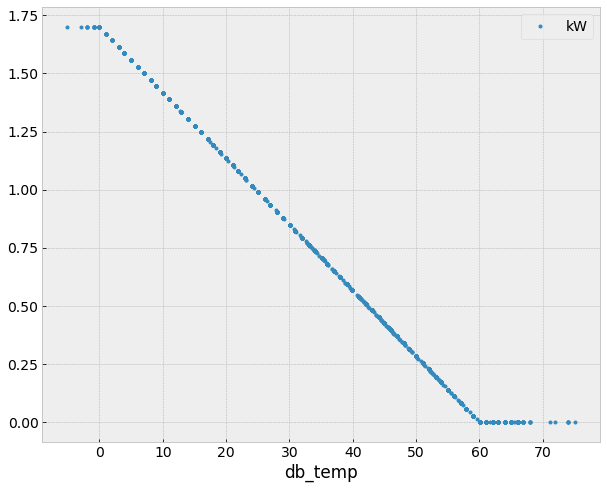

In [22]:
df_hourly.plot(x='db_temp', y='kW', marker='.', linewidth=0)